# Project Workflow & Notebook Guide

This notebook analyses peptide data by comparing **expected** vs **observed** values and exploring their relationships with sequence-level features.
To make the flow clear and reproducible, here's how the notebook is structured:

1. **Setup & Configuration**  
   - Imports, display options, and (if present) a global random seed for reproducibility.
   - Paths and lightweight utility helpers.

2. **Data Loading**  
   - Load the cleaned dataset(s) used for analysis.  
   - Basic sanity checks (shape, columns, missing values).

3. **Preprocessing**  
   - Optional filtering or type casting.  
   - Derivation of helper columns (e.g., deltas, ratios, binned groups).

4. **Exploratory Data Analysis (EDA)**  
   - Summary statistics and distributions for expected vs. observed.  
   - Outlier inspection and correlations.  
   - Grouped summaries (by peptide features, charge state, modifications, etc.).

5. **Visualizations**  
   - Scatter/hexbin/density plots for expected vs. observed.  
   - Histograms/boxplots/violin plots for key metrics.  
   - Faceted views by relevant categorical variables.

6. **Modeling / Diagnostics (if present)**  
   - Simple baselines or regression-style fits for bias/variance inspection.  
   - Residual analysis and goodness-of-fit summaries.

7. **Reporting & Export**  
   - Save selected tables/figures to disk (if applicable).  
   - Compact summary of main findings.

> **Tip:** Cells are ordered so you can run the notebook from top to bottom. Nothing below has been changed functionally; only this guide has been added and outputs cleared for a leaner file. If you need to customize paths or parameters, do so in the setup/config cells.


Notes: Tools for digestion https://proteowizard.sourceforge.io/ and https://proteowizard.sourceforge.io/tools/chainsaw.html , disscus the methoinin is missing 




# **S. aureus Newman** — Peptide EDA & ML (Cleaned Files)

This notebook is tailored to your **cleaned** Excel layouts:

- **Theoretical digestion** (`main` sheet):  
  Columns: `Protein_Name, Sequence, Unique_ID, Monoisotopic_Mass, Predicted_NET, Tryptic_Name, Valid`

- **SILAC** (`main` sheet):  
  Columns include: `Sequence`, amino-acid context columns, `Proteins`, `Leading razor protein`, uniqueness flags, `PEP`, `Score`, many **Ratio H/L** columns, and many **Intensity** columns.

- **Label-free** (`main` sheet):  
  Similar to SILAC but without H/L ratios; includes `Sequence`, `Proteins`, `Leading razor protein`, and **Intensity** columns.

**What this notebook produces**
- Joins **theoretical** and **observed** peptides by `(protein_id, peptide)`
- Computes **observed peptide frequency** across experiments (count of experiment/intensity columns with signal) and **sum intensity**
- Flags **missing** and **unexpected** peptides
- Adds **peptide features** (length, AA composition, KD hydropathy, charge, ± BioPython gravy/pI)
- Trains an **ML model** (group splits by protein) that predicts detectability
- Saves a **clean dataset** ready for downstream analyses


In [ ]:

# Paths (update if needed)
paths = {
    "label_free": "S. aureus Newmann_Lable-free.xlsx",
    "silac": "S. aureus Newmann_SILAC.xlsx",
    "theoretical": "S. aureus Newmann_theoretical_digestion.xlsx",
    "fasta": "Staph_aureus_newman.fasta",
}

# Optional installs (uncomment in your environment if needed)
#! pip install biopython scikit-learn pyteomics matplotlib pandas numpy openpyxl modlamp


In [ ]:

import re, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
BIOPYTHON_OK = True


def strip_mods(seq: str) -> str:
    if seq is None: return None
    s = str(seq)
    s = re.sub(r"\(.*?\)", "", s)  # remove (...) mods
    s = re.sub(r"\[.*?\]", "", s)  # remove [...] mods
    s = re.sub(r"[^A-Za-z]", "", s)
    return s.upper()

def first_protein_id(val):
    if val is None or (isinstance(val, float) and np.isnan(val)): return None
    s = str(val)
    # maxquant often separates proteins by ';'
    return s.split(";")[0].strip()

def read_fasta_map(path):
    prot2seq = {}
    try:
        for rec in SeqIO.parse(path, "fasta"):
            prot2seq[str(rec.id)] = str(rec.seq)
    except Exception:
        # minimal fallback
        with open(path, "r") as fh:
            header, seq = None, []
            for line in fh:
                line=line.strip()
                if not line: continue
                if line.startswith(">"):
                    if header: prot2seq[header] = "".join(seq)
                    header = line[1:].split()[0]; seq=[]
                else:
                    seq.append(line)
            if header: prot2seq[header] = "".join(seq)
    return prot2seq

def map_protein_sequence(pid, prot2seq):
    if pid is None: return None
    if pid in prot2seq: return prot2seq[pid]
    key = str(pid).split()[0]
    if key in prot2seq: return prot2seq[key]
    key = str(pid).split("|")[-1]
    if key in prot2seq: return prot2seq[key]
    return None


In [ ]:
# --- Theoretical digestion (main sheet) + FASTA mapping with best-match rewrite ---

import re, math, difflib
import numpy as np
import pandas as pd

# 1) Load theoretical
theo_raw = pd.read_excel(paths["theoretical"], sheet_name="main")
theo_raw.columns = [str(c).strip() for c in theo_raw.columns]

# Expected columns
req_cols = ["Protein_Name","Sequence","Unique_ID","Monoisotopic_Mass","Predicted_NET","Tryptic_Name","Valid"]
missing = [c for c in req_cols if c not in theo_raw.columns]
if missing:
    print("WARNING: Missing columns in theoretical file:", missing)

theo = theo_raw.rename(columns={
    "Protein_Name":"protein_id",
    "Sequence":"peptide",
    "Valid":"valid"
})[["protein_id","peptide","valid"]].copy()

# Clean peptide strings
theo["peptide"] = theo["peptide"].map(strip_mods)
# Use first protein id if there are ';' lists
theo["protein_id"] = theo["protein_id"].map(first_protein_id)
theo = theo.dropna(subset=["peptide"])
theo = theo[["protein_id","peptide"]].drop_duplicates()

# 2) Load FASTA into dict: full header -> sequence
prot2seq = read_fasta_map(paths["fasta"])
if not prot2seq:
    raise ValueError("FASTA file appears empty or unreadable: {}".format(paths["fasta"]))

# 3) Build relaxed lookup structures for best matching

def normalize_token(s: str) -> str:
    """Uppercase, strip spaces, remove common wrappers and version suffixes (e.g., .2)."""
    if s is None:
        return ""
    s = str(s).strip()
    # Remove surrounding whitespace and lowercase/uppercase normalization
    s = s.replace(" ", "")
    s_up = s.upper()
    # Drop GI/REF wrappers (gi|...|ref|...|)
    # Keep the last token after '|' if it looks like an accession-like substring
    parts = [p for p in s_up.split("|") if p]
    if len(parts) >= 1:
        # Heuristic: prefer the last accession-like token if present
        cand = parts[-1]
    else:
        cand = s_up
    # Remove trailing .version (e.g., YP_001331184.2 -> YP_001331184)
    cand = re.sub(r"\.(\d+)$", "", cand)
    return cand

# Index FASTA by multiple keys
fasta_headers = list(prot2seq.keys())
norm_to_header = {}          # normalized key -> header
token_to_headers = {}        # token -> set(headers) for token-level lookup
all_norm_headers = []        # list of normalized headers for fuzzy

for hdr in fasta_headers:
    norm_hdr = normalize_token(hdr)
    all_norm_headers.append(norm_hdr)
    # direct normalized map (keep first seen if duplicates)
    norm_to_header.setdefault(norm_hdr, hdr)
    # also index all pipe/space tokens
    raw_tokens = re.split(r"[|\s]", hdr)
    for t in raw_tokens:
        t_norm = normalize_token(t)
        if not t_norm:
            continue
        token_to_headers.setdefault(t_norm, set()).add(hdr)

def best_fasta_match(pid: str):
    """
    Return (best_header, sequence) for a given protein_id using layered matching:
      1) exact header key
      2) exact normalized key
      3) token match (normalized tokens)
      4) substring containment (normalized)
      5) fuzzy best match on normalized headers
    If no match -> return (None, None)
    """
    if pid is None or (isinstance(pid, float) and math.isnan(pid)):
        return (None, None)

    # 1) exact header
    if pid in prot2seq:
        return (pid, prot2seq[pid])

    pid_norm = normalize_token(pid)

    # 2) exact normalized
    if pid_norm in norm_to_header:
        h = norm_to_header[pid_norm]
        return (h, prot2seq[h])

    # 3) token match
    if pid_norm in token_to_headers:
        # Choose the first deterministically (could refine with longest sequence, etc.)
        h = sorted(token_to_headers[pid_norm])[0]
        return (h, prot2seq[h])

    # 4) substring containment among normalized headers (both directions)
    #    e.g., pid_norm in norm_hdr or norm_hdr in pid_norm
    for norm_hdr, h in norm_to_header.items():
        if pid_norm and (pid_norm in norm_hdr or norm_hdr in pid_norm):
            return (h, prot2seq[h])

    # 5) fuzzy match on normalized headers
    close = difflib.get_close_matches(pid_norm, all_norm_headers, n=1, cutoff=0.8)
    if close:
        h = norm_to_header[close[0]]
        return (h, prot2seq[h])

    return (None, None)

# 4) Apply best-match mapping; rewrite protein_id to FASTA header and attach sequence
mapped_headers = []
mapped_seqs = []
unmatched = []

for pid in theo["protein_id"].astype(str).tolist():
    h, seq = best_fasta_match(pid)
    if h is None or seq is None:
        unmatched.append(pid)
        mapped_headers.append(None)
        mapped_seqs.append(None)
    else:
        mapped_headers.append(h)   # rewrite id to the FASTA header actually matched
        mapped_seqs.append(seq)

theo["protein_id_fasta"] = mapped_headers
theo["protein_sequence"] = mapped_seqs

# Use FASTA header as the final id (as you requested)
theo["protein_id"] = theo["protein_id_fasta"]
theo = theo.drop(columns=["protein_id_fasta"])

# 5) Error if any protein IDs could not be matched
if len(unmatched) > 0:
    examples = list(dict.fromkeys(unmatched))[:10]  # unique first 10
    raise ValueError(
        "Could not match {} theoretical protein_id(s) to FASTA. "
        "Examples: {}".format(len(unmatched), examples)
    )

# Final tidy theoretical table
theo = theo[["protein_id","protein_sequence","peptide"]].drop_duplicates()
theo.head(10)


,protein_id,protein_sequence,peptide
0,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,AFIETYQQQHPDDEVK
1,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,HIDLFETYIPVIDK
2,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,DVLTGWGK
3,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,MSNGETLTDDEQMK
4,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,MSNGETLTDDEQMKVSR
5,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,VSRLSDILEEFLSADK
6,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,LSDILEEFLSADK
7,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,AYIDAISIAGK
8,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,AYIDAISIAGKTFK
9,gi|229577671|ref|YP_001331184.2|,MAKVLYITAHPFNELVSNSMAAGKAFIETYQQQHPDDEVKHIDLFE...,TFKYSAEGPQGLLTDK


In [ ]:
# --- SILAC (main sheet) — with FASTA best-match mapping and strict ID rewrite ---

import numpy as np
import pandas as pd

silac_raw = pd.read_excel(paths["silac"], sheet_name="main")
silac_raw.columns = [str(c).strip() for c in silac_raw.columns]

# Column basics
silac_seq_col = "Sequence"
silac_prot_col = "Leading razor protein" if "Leading razor protein" in silac_raw.columns else "Proteins"

if silac_seq_col not in silac_raw.columns:
    raise ValueError("SILAC 'Sequence' column not found")

if silac_prot_col not in silac_raw.columns:
    print("WARNING: Neither 'Leading razor protein' nor 'Proteins' found; protein ids will be None")

# Identify experiment / intensity columns
ratio_cols = [c for c in silac_raw.columns if c.startswith("Ratio H/L")]
intensity_cols = [c for c in silac_raw.columns if c.startswith("Intensity")]

# Build observed rows (peptide + (leading) protein + intensities)
keep_cols = [silac_seq_col] + ([silac_prot_col] if silac_prot_col in silac_raw.columns else []) + intensity_cols
sdf = silac_raw[keep_cols].copy()
sdf = sdf.rename(columns=({silac_seq_col: "peptide"} | ({silac_prot_col: "protein_id"} if silac_prot_col in silac_raw.columns else {})))

# Clean peptide and normalize protein id list
sdf["peptide"] = sdf["peptide"].map(strip_mods)
if "protein_id" in sdf.columns:
    sdf["protein_id"] = sdf["protein_id"].map(first_protein_id)
else:
    sdf["protein_id"] = None

# Load FASTA map if not already loaded
try:
    prot2seq
except NameError:
    prot2seq = read_fasta_map(paths["fasta"])

if not prot2seq:
    raise ValueError(f"FASTA file appears empty or unreadable: {paths['fasta']}")

# Use the same best-match logic as in the theoretical cell
# Assumes you already defined: normalize_token(..) and best_fasta_match(..)
# If best_fasta_match is not defined (e.g., you chose to use map_protein_sequence earlier),
# we fall back to map_protein_sequence(pid, prot2seq) for matching.

def map_protein_to_fasta(pid):
    if pid is None or (isinstance(pid, float) and np.isnan(pid)):
        return (None, None)
    try:
        # Preferred: layered matcher from the theoretical cell
        h, seq = best_fasta_match(pid)
        return (h, seq)
    except NameError:
        # Fallback: exact/relaxed mapper if you only defined map_protein_sequence
        seq = map_protein_sequence(pid, prot2seq)
        return (pid if seq else None, seq)

mapped_headers = []
mapped_seqs = []
unmatched = []

for pid in sdf["protein_id"].astype(str).tolist():
    h, seq = map_protein_to_fasta(pid)
    if h is None or seq is None:
        unmatched.append(pid)
        mapped_headers.append(None)
        mapped_seqs.append(None)
    else:
        mapped_headers.append(h)   # rewrite id to the matched FASTA header
        mapped_seqs.append(seq)

# Enforce strict matching: raise if any missing
if len(unmatched) > 0:
    examples = list(dict.fromkeys(unmatched))[:10]
    raise ValueError(
        f"[SILAC] Could not match {len(unmatched)} protein_id(s) to FASTA. Examples: {examples}"
    )

# Rewrite IDs and attach sequence
sdf["protein_id"] = mapped_headers
sdf["protein_sequence"] = mapped_seqs

# Observed frequency = number of intensity columns with positive values
def count_positive(row):
    return int(np.sum([(x if pd.notna(x) else 0) > 0 for x in row]))

sdf["observed_frequency"]   = sdf[intensity_cols].apply(count_positive, axis=1) if intensity_cols else 1
sdf["observed_intensity_sum"] = sdf[intensity_cols].sum(axis=1, numeric_only=True) if intensity_cols else np.nan

# Aggregate SILAC per (protein_id, protein_sequence, peptide) — still SILAC-only
silac = (
    sdf[["protein_id","protein_sequence","peptide","observed_frequency","observed_intensity_sum"]]
    .groupby(["protein_id","protein_sequence","peptide"], dropna=False)
    .agg(
        observed_frequency=("observed_frequency","sum"),
        observed_intensity_sum=("observed_intensity_sum","sum")
    )
    .reset_index()
)

silac.head(10)


,protein_id,protein_sequence,peptide,observed_frequency,observed_intensity_sum
0,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,AYNPLFIYGGVGLGK,42,157109609.0
1,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,DLKEDPIFK,27,45197220.0
2,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,DNEGEAFR,15,3001361.0
3,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,DTELYTIK,36,33482683.0
4,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,EIAQLEDR,15,18076857.0
5,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,ELEGALTR,36,51247281.0
6,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,ELTDFSLPK,45,303972680.0
7,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,FPHAASLAVAEAPAK,24,51820500.0
8,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,FTNEFIK,45,164684340.0
9,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,IEDFSAK,45,33159202.0


In [ ]:
# --- Label-free (main sheet) — with FASTA best-match mapping and strict ID rewrite ---

import numpy as np
import pandas as pd

lf_raw = pd.read_excel(paths["label_free"], sheet_name="main")
lf_raw.columns = [str(c).strip() for c in lf_raw.columns]

lf_seq_col  = "Sequence"
lf_prot_col = "Leading razor protein" if "Leading razor protein" in lf_raw.columns else "Proteins"

if lf_seq_col not in lf_raw.columns:
    raise ValueError("Label-free 'Sequence' column not found")

if lf_prot_col not in lf_raw.columns:
    print("WARNING: Neither 'Leading razor protein' nor 'Proteins' found in label-free; protein ids will be None")

# Identify intensity columns
lf_intensity_cols = [c for c in lf_raw.columns if c.startswith("Intensity")]

# Build observed rows
keep_cols = [lf_seq_col] + ([lf_prot_col] if lf_prot_col in lf_raw.columns else []) + lf_intensity_cols
ldf = lf_raw[keep_cols].copy()
ldf = ldf.rename(columns=({lf_seq_col: "peptide"} | ({lf_prot_col: "protein_id"} if lf_prot_col in lf_raw.columns else {})))

# Clean peptide / normalize protein id list
ldf["peptide"] = ldf["peptide"].map(strip_mods)
if "protein_id" in ldf.columns:
    ldf["protein_id"] = ldf["protein_id"].map(first_protein_id)
else:
    ldf["protein_id"] = None

# Ensure FASTA map is available
try:
    prot2seq
except NameError:
    prot2seq = read_fasta_map(paths["fasta"])
if not prot2seq:
    raise ValueError(f"FASTA file appears empty or unreadable: {paths['fasta']}")

# Use same best-match logic as before
def map_protein_to_fasta(pid):
    if pid is None or (isinstance(pid, float) and np.isnan(pid)):
        return (None, None)
    try:
        h, seq = best_fasta_match(pid)  # from theoretical cell
        return (h, seq)
    except NameError:
        # fallback: simpler mapper if only map_protein_sequence is defined
        seq = map_protein_sequence(pid, prot2seq)
        return (pid if seq else None, seq)

mapped_headers = []
mapped_seqs = []
unmatched = []

for pid in ldf["protein_id"].astype(str).tolist():
    h, seq = map_protein_to_fasta(pid)
    if h is None or seq is None:
        unmatched.append(pid)
        mapped_headers.append(None)
        mapped_seqs.append(None)
    else:
        mapped_headers.append(h)   # rewrite to matched FASTA header
        mapped_seqs.append(seq)

# Enforce strict matching
if len(unmatched) > 0:
    examples = list(dict.fromkeys(unmatched))[:10]
    raise ValueError(
        f"[Label-free] Could not match {len(unmatched)} protein_id(s) to FASTA. Examples: {examples}"
    )

# Rewrite IDs and attach sequence
ldf["protein_id"] = mapped_headers
ldf["protein_sequence"] = mapped_seqs

# Observed frequency = number of intensity columns with positive values
def count_positive(row):
    return int(np.sum([(x if pd.notna(x) else 0) > 0 for x in row]))

ldf["observed_frequency"]     = ldf[lf_intensity_cols].apply(count_positive, axis=1) if lf_intensity_cols else 1
ldf["observed_intensity_sum"] = ldf[lf_intensity_cols].sum(axis=1, numeric_only=True)   if lf_intensity_cols else np.nan

# Aggregate Label-free per (protein_id, protein_sequence, peptide)
labelfree = (
    ldf[["protein_id","protein_sequence","peptide","observed_frequency","observed_intensity_sum"]]
    .groupby(["protein_id","protein_sequence","peptide"], dropna=False)
    .agg(
        observed_frequency=("observed_frequency","sum"),
        observed_intensity_sum=("observed_intensity_sum","sum")
    )
    .reset_index()
)

labelfree.head(10)


,protein_id,protein_sequence,peptide,observed_frequency,observed_intensity_sum
0,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,AYNPLFIYGGVGLGK,11,25094390
1,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,DTELYTIK,8,3060993
2,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,EIAQLEDR,15,14467370
3,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,ELTDFSLPK,15,36410210
4,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,FTNEFIK,15,21446040
5,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,IEDFSAK,14,4055222
6,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,IGEEFGGR,12,5756257
7,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,ITIQDIQK,15,23988540
8,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,IVGQYYNVR,15,29221590
9,gi|151220213|ref|YP_001331036.1|,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...,LSAVSYSTFLK,14,17145550


In [ ]:
# ============================================================
# UNIFIED PRESENCE PIPELINE (per-experiment; full outer merge)
# Categories:
#   1: Theoretical peptide; peptide NOT observed AND protein NOT observed
#   2: Theoretical peptide; peptide NOT observed BUT protein observed (≥1 other peptide)
#   3: Theoretical peptide; peptide & protein observed (pair matches)
#   4: Theoretical peptide; peptide observed BUT under a DIFFERENT protein
#   5: NOT theoretical; peptide observed in this experiment
#   6: Special combine case → one experiment is 5 and the other is missing (set missing to 6)
#      NOTE: (5, NaN) + (NaN, 5) across duplicate rows must resolve to (5, 5), NOT (6, 5) / (5, 6)
# ============================================================

import pandas as pd

# ---- Labels (short & clear) ----
PRESENCE_LABELS = {
    1: "Peptide predicted, protein not seen",
    2: "Peptide predicted, protein seen",
    3: "Peptide & protein predicted and Seen",
    4: "Peptide seen under other protein Id",
    5: "Peptide seen, but not predicted",
    6: "Peptide seen only in other experiment",
}

# ------------------------------------------------------------
# Step 1: Aggregate experimental data
# ------------------------------------------------------------
def aggregate_experiment(df, freq_col, intensity_col, prefix):
    """Aggregate experimental data per (protein_id, peptide)."""
    out = (
        df.groupby(["protein_id", "peptide"], dropna=False)
          .agg(
              **{
                  f"observed_frequency_{prefix}": (freq_col, "sum"),
                  f"observed_intensity_sum_{prefix}": (intensity_col, "sum"),
              }
          )
          .reset_index()
    )
    return out

silac_obs      = aggregate_experiment(silac,     "observed_frequency", "observed_intensity_sum", "SILAC")
labelfree_obs  = aggregate_experiment(labelfree, "observed_frequency", "observed_intensity_sum", "Label_free")

# ------------------------------------------------------------
# Step 2: Build lookup sets (per experiment)
# ------------------------------------------------------------
theo_keys          = set(zip(theo["protein_id"], theo["peptide"]))
silac_keys         = set(zip(silac_obs["protein_id"], silac_obs["peptide"]))
labelfree_keys     = set(zip(labelfree_obs["protein_id"], labelfree_obs["peptide"]))
silac_peps         = set(silac_obs["peptide"])
labelfree_peps     = set(labelfree_obs["peptide"])
silac_proteins     = {pid for pid, _ in silac_keys}
labelfree_proteins = {pid for pid, _ in labelfree_keys}

# ------------------------------------------------------------
# Step 3: Classifier (per experiment) for categories 1–4
# ------------------------------------------------------------
def classify_theoretical(pid, pep, exp_keys, exp_peps, proteins_with_peptides):
    """
    Classify a THEORETICAL (pid, pep) into categories 1–4 for a single experiment.

    Rules (order matters):
      3: (pid,pep) observed under SAME protein (pair match)
      4: peptide observed, but under a DIFFERENT protein (not under pid, but pep seen elsewhere)
      2: peptide NOT observed, BUT protein observed (≥1 other peptide under pid)
      1: peptide NOT observed AND protein NOT observed
    """
    pair_seen = (pid, pep) in exp_keys
    pep_seen_elsewhere = (pep in exp_peps) and not pair_seen
    prot_seen = pid in proteins_with_peptides

    if pair_seen:
        return 3
    if pep_seen_elsewhere:
        return 4
    if prot_seen:
        return 2
    return 1

# ------------------------------------------------------------
# Step 4: Build per-experiment presence DataFrame
# ------------------------------------------------------------
def build_presence_for_experiment(theo_df, exp_obs, exp_keys, exp_peps, proteins_with_peptides, exp_prefix):
    """
    Start from theoretical peptides and:
      - assign categories 1–4 for each theoretical (pid,pep)
      - add category 5 rows for observed (pid,pep) NOT present in theoretical
      - attach experiment metrics for convenience
    Returns: DataFrame with columns:
      protein_id, peptide, presence_{exp_prefix}, observed_frequency_{exp_prefix}, observed_intensity_sum_{exp_prefix}
    """
    # Theoretical base with presence (1–4)
    df_th = theo_df[["protein_id", "peptide"]].copy()
    df_th[f"presence_{exp_prefix}"] = df_th.apply(
        lambda r: classify_theoretical(r["protein_id"], r["peptide"], exp_keys, exp_peps, proteins_with_peptides),
        axis=1,
    )

    # Attach metrics for theoretical pairs if present in experiment (else zeros)
    metrics = exp_obs.set_index(["protein_id", "peptide"])
    df_th = df_th.join(metrics, on=["protein_id", "peptide"])
    df_th[f"observed_frequency_{exp_prefix}"] = df_th[f"observed_frequency_{exp_prefix}"].fillna(0).astype(int)
    df_th[f"observed_intensity_sum_{exp_prefix}"] = df_th[f"observed_intensity_sum_{exp_prefix}"].fillna(0.0)

    # Observed but NOT theoretical → category 5
    not_theo_mask = ~exp_obs.set_index(["protein_id", "peptide"]).index.isin(theo_keys)
    df_obs_not_theo = exp_obs.loc[not_theo_mask, ["protein_id", "peptide",
                                                  f"observed_frequency_{exp_prefix}",
                                                  f"observed_intensity_sum_{exp_prefix}"]].copy()
    df_obs_not_theo[f"presence_{exp_prefix}"] = 5

    # Combine and ensure dtypes
    out = pd.concat([df_th, df_obs_not_theo], ignore_index=True)
    out[f"presence_{exp_prefix}"] = out[f"presence_{exp_prefix}"].astype("Int64")
    return out[["protein_id", "peptide",
                f"presence_{exp_prefix}",
                f"observed_frequency_{exp_prefix}",
                f"observed_intensity_sum_{exp_prefix}"]]

# Build per-experiment parts
part_silac = build_presence_for_experiment(
    theo, silac_obs, silac_keys, silac_peps, silac_proteins, "SILAC"
)
part_lf = build_presence_for_experiment(
    theo, labelfree_obs, labelfree_keys, labelfree_peps, labelfree_proteins, "Label_free"
)

# ------------------------------------------------------------
# Step 5: Full outer merge of experiments on (protein_id, peptide)
# ------------------------------------------------------------
unified = pd.merge(
    part_silac, part_lf,
    on=["protein_id", "peptide"],
    how="outer"
)

# ------------------------------------------------------------
# Step 6: Resolve duplicates & special category 6, per key
#   - If we have multiple rows for same key (rare), reduce to one by rules.
#   - (5, NaN) + (NaN, 5) across duplicate rows ⇒ single row with (5, 5)
#   - If exactly one side is 5 and the other truly missing → set missing to 6
# ------------------------------------------------------------
def _resolve_presence_group(g):
    # Collect present values
    silac_vals = g["presence_SILAC"].dropna().tolist()
    lf_vals    = g["presence_Label_free"].dropna().tolist()

    # Pick a single value per experiment; if multiple, prefer 5 if present
    def pick(vals):
        if not vals:
            return pd.NA
        return 5 if 5 in vals else vals[0]

    silac_final = pick(silac_vals)
    lf_final    = pick(lf_vals)

    # Cross-fill special case:
    # - If SILAC missing but LF has 5 → SILAC becomes 6
    # - If LF missing but SILAC has 5 → LF becomes 6
    if pd.isna(silac_final) and (5 in lf_vals):
        silac_final = 6
    if pd.isna(lf_final) and (5 in silac_vals):
        lf_final = 6

    return pd.Series({"presence_SILAC": silac_final, "presence_Label_free": lf_final})

presence_resolved = (
    unified.groupby(["protein_id", "peptide"], as_index=False)
           .apply(_resolve_presence_group)
           .reset_index(drop=True)
)

# Keep one row per key for the numeric metrics (sum duplicates just in case)
metric_cols = [c for c in unified.columns if c.startswith("observed_frequency_") or c.startswith("observed_intensity_sum_")]
metrics_agg = (
    unified[["protein_id", "peptide"] + metric_cols]
      .groupby(["protein_id", "peptide"], as_index=False)
      .sum(numeric_only=True)
)

unified = metrics_agg.merge(presence_resolved, on=["protein_id", "peptide"], how="left")
unified["presence_SILAC"] = unified["presence_SILAC"].astype("Int64")
unified["presence_Label_free"] = unified["presence_Label_free"].astype("Int64")

# ------------------------------------------------------------
# Step 7: Final enrichments (optional)
# ------------------------------------------------------------
unified["pep_len"] = unified["peptide"].fillna("").astype(str).str.len()

try:
    unified["protein_sequence"] = unified["protein_id"].apply(lambda k: map_protein_sequence(k, prot2seq))
except Exception:
    unified["protein_sequence"] = None

# Sanity: unique keys
unified = unified.drop_duplicates(subset=["protein_id", "peptide"], keep="first").reset_index(drop=True)

print(f"Unified rows (per-experiment): {len(unified):,}")
display(unified.head(12))


/tmp/ipykernel_126312/3214206455.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_resolve_presence_group)


Unified rows (per-experiment): 74,413


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
0,gi|151220213|ref|YP_001331036.1|,AYNPLFIYGGVGLGK,42.0,157109609.0,11.0,25094390.0,3,3,15,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
1,gi|151220213|ref|YP_001331036.1|,DHTTVIHAHEK,0.0,0.0,0.0,0.0,2,2,11,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
2,gi|151220213|ref|YP_001331036.1|,DHTTVIHAHEKISK,0.0,0.0,0.0,0.0,2,2,14,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
3,gi|151220213|ref|YP_001331036.1|,DIIQAPK,0.0,0.0,0.0,0.0,2,2,7,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
4,gi|151220213|ref|YP_001331036.1|,DIIQAPKSK,0.0,0.0,0.0,0.0,2,2,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
5,gi|151220213|ref|YP_001331036.1|,DLKEDPIFK,27.0,45197220.0,0.0,0.0,3,2,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
6,gi|151220213|ref|YP_001331036.1|,DNEGEAFR,15.0,3001361.0,0.0,0.0,3,2,8,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
7,gi|151220213|ref|YP_001331036.1|,DNEGEAFRER,0.0,0.0,0.0,0.0,2,2,10,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
8,gi|151220213|ref|YP_001331036.1|,DTELYTIK,36.0,33482683.0,8.0,3060993.0,3,3,8,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
9,gi|151220213|ref|YP_001331036.1|,EDPIFK,0.0,0.0,0.0,0.0,2,2,6,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...


In [ ]:
target = 'NTMQAATKPGITTK'

print(theo[theo["peptide"] == target].head())
print(labelfree[labelfree["peptide"] == target].head())
print(silac[silac["peptide"] == target].head())

                             protein_id  \
20467  gi|151222038|ref|YP_001332860.1|   

                                        protein_sequence         peptide  
20467  MIVKTEEELQALKEIGYICAKVRNTMQAATKPGITTKELDNIAKEL...  NTMQAATKPGITTK  
                            protein_id  \
8040  gi|151222038|ref|YP_001332860.1|   

                                       protein_sequence         peptide  \
8040  MIVKTEEELQALKEIGYICAKVRNTMQAATKPGITTKELDNIAKEL...  NTMQAATKPGITTK   

      observed_frequency  observed_intensity_sum  
8040                   9                 6871367  
                            protein_id  \
9217  gi|151222038|ref|YP_001332860.1|   

                                       protein_sequence         peptide  \
9217  MIVKTEEELQALKEIGYICAKVRNTMQAATKPGITTKELDNIAKEL...  NTMQAATKPGITTK   

      observed_frequency  observed_intensity_sum  
9217                  24              47616020.0  


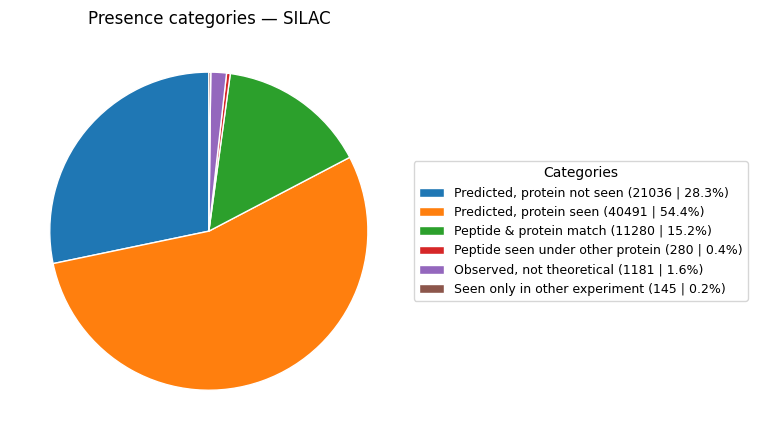

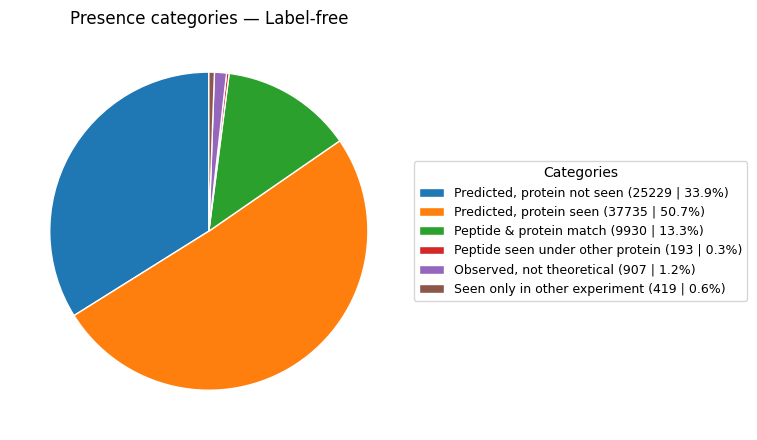

,Category,SILAC,Label-free
0,"Predicted, protein not seen",21036,25229
1,"Predicted, protein seen",40491,37735
2,Peptide & protein match,11280,9930
3,Peptide seen under other protein,280,193
4,"Observed, not theoretical",1181,907
5,Seen only in other experiment,145,419


In [ ]:
# --- Presence code distribution with TEXT labels (per experiment) ---
# Expects 'unified' with columns: presence_SILAC, presence_Label_free

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Order to display
ORDER = [ 1, 2, 3, 4, 5, 6]

import matplotlib.pyplot as plt

def presence_pie_text(series, title):
    # Count including NaN, reindex to include all categories
    counts = series.value_counts(dropna=False).reindex(ORDER, fill_value=0)
    labels = [PRESENCE_LABELS[k] for k in counts.index]
    sizes = counts.values
    total = sizes.sum()

    # Build display labels with percentages
    display_labels = [
        f"{lab} ({int(val)} | {0.0 if total==0 else 100*val/total:.1f}%)"
        for lab, val in zip(labels, sizes)
    ]

    fig, ax = plt.subplots(figsize=(8, 4.5))  # adjust aspect ratio for better text spacing
    wedges, texts = ax.pie(
        sizes,
        startangle=90,            # rotate for consistent layout
        wedgeprops={"linewidth": 1, "edgecolor": "white"}
    )

    # Use legend instead of inline labels (avoids overlap)
    ax.legend(
        wedges,
        display_labels,
        title="Categories",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize=9,
    )

    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()


# SILAC pie
presence_pie_text(unified["presence_SILAC"], "Presence categories — SILAC")

# Label-free pie
presence_pie_text(unified["presence_Label_free"], "Presence categories — Label-free")

# Optional: tabular summary with text labels
summary = pd.DataFrame({
    "Category": [PRESENCE_LABELS[k] for k in ORDER],
    "SILAC": [
        (unified["presence_SILAC"]==k).sum() if not (isinstance(k, float) and np.isnan(k))
        else unified["presence_SILAC"].isna().sum()
        for k in ORDER
    ],
    "Label-free": [
        (unified["presence_Label_free"]==k).sum() if not (isinstance(k, float) and np.isnan(k))
        else unified["presence_Label_free"].isna().sum()
        for k in ORDER
    ],
})
summary


In [ ]:

prot2seq = read_fasta_map(paths["fasta"])
unified["protein_sequence"] = unified["protein_id"].apply(lambda pid: map_protein_sequence(pid, prot2seq))
unified.head(8)


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
0,gi|151220213|ref|YP_001331036.1|,AYNPLFIYGGVGLGK,42.0,157109609.0,11.0,25094390.0,3,3,15,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
1,gi|151220213|ref|YP_001331036.1|,DHTTVIHAHEK,0.0,0.0,0.0,0.0,2,2,11,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
2,gi|151220213|ref|YP_001331036.1|,DHTTVIHAHEKISK,0.0,0.0,0.0,0.0,2,2,14,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
3,gi|151220213|ref|YP_001331036.1|,DIIQAPK,0.0,0.0,0.0,0.0,2,2,7,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
4,gi|151220213|ref|YP_001331036.1|,DIIQAPKSK,0.0,0.0,0.0,0.0,2,2,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
5,gi|151220213|ref|YP_001331036.1|,DLKEDPIFK,27.0,45197220.0,0.0,0.0,3,2,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
6,gi|151220213|ref|YP_001331036.1|,DNEGEAFR,15.0,3001361.0,0.0,0.0,3,2,8,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
7,gi|151220213|ref|YP_001331036.1|,DNEGEAFRER,0.0,0.0,0.0,0.0,2,2,10,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...


In [ ]:
# Show example rows from `unified` for each defined category
# using the PRESENCE_LABELS dictionary

category_column1 = "presence_SILAC"
category_column2 = "presence_Label_free"
n_examples = 5  # number of examples per category to show


for code, label in PRESENCE_LABELS.items():
    print("=" * 100)
    print(f"Category {code}: {label}")
    print("-" * 100)

    # --- SILAC examples ---
    silac_subset = unified[unified[category_column1] == code]
    print(f"[SILAC — {len(silac_subset)} rows total]")
    if silac_subset.empty:
        print("  (no rows for this category in SILAC)")
    else:
        display(silac_subset.head(n_examples))

    # --- Label-free examples ---
    labelfree_subset = unified[unified[category_column2] == code]
    print(f"[Label-free — {len(labelfree_subset)} rows total]")
    if labelfree_subset.empty:
        print("  (no rows for this category in Label-free)")
    else:
        display(labelfree_subset.head(n_examples))

    print("\n")


Category 1: Predicted, protein not seen
----------------------------------------------------------------------------------------------------
[SILAC — 21036 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
327,gi|151220219|ref|YP_001331042.1|,DIEAVAQYLK,0.0,0.0,0.0,0.0,1,1,10,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...
328,gi|151220219|ref|YP_001331042.1|,DSDDVLR,0.0,0.0,0.0,0.0,1,1,7,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...
329,gi|151220219|ref|YP_001331042.1|,DSDDVLRELNR,0.0,0.0,0.0,0.0,1,1,11,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...
330,gi|151220219|ref|YP_001331042.1|,DWLEGSTLTTR,0.0,0.0,0.0,0.0,1,1,11,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...
331,gi|151220219|ref|YP_001331042.1|,DWLEGSTLTTRQSEIR,0.0,0.0,0.0,0.0,1,1,16,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...


[Label-free — 25229 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
327,gi|151220219|ref|YP_001331042.1|,DIEAVAQYLK,0.0,0.0,0.0,0.0,1,1,10,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...
328,gi|151220219|ref|YP_001331042.1|,DSDDVLR,0.0,0.0,0.0,0.0,1,1,7,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...
329,gi|151220219|ref|YP_001331042.1|,DSDDVLRELNR,0.0,0.0,0.0,0.0,1,1,11,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...
330,gi|151220219|ref|YP_001331042.1|,DWLEGSTLTTR,0.0,0.0,0.0,0.0,1,1,11,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...
331,gi|151220219|ref|YP_001331042.1|,DWLEGSTLTTRQSEIR,0.0,0.0,0.0,0.0,1,1,16,MTLYLDGETLTIEDIKSFLQQQSKIEIIDDALERVKKSRAVVERII...




Category 2: Predicted, protein seen
----------------------------------------------------------------------------------------------------
[SILAC — 40491 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
1,gi|151220213|ref|YP_001331036.1|,DHTTVIHAHEK,0.0,0.0,0.0,0.0,2,2,11,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
2,gi|151220213|ref|YP_001331036.1|,DHTTVIHAHEKISK,0.0,0.0,0.0,0.0,2,2,14,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
3,gi|151220213|ref|YP_001331036.1|,DIIQAPK,0.0,0.0,0.0,0.0,2,2,7,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
4,gi|151220213|ref|YP_001331036.1|,DIIQAPKSK,0.0,0.0,0.0,0.0,2,2,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
7,gi|151220213|ref|YP_001331036.1|,DNEGEAFRER,0.0,0.0,0.0,0.0,2,2,10,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...


[Label-free — 37735 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
1,gi|151220213|ref|YP_001331036.1|,DHTTVIHAHEK,0.0,0.0,0.0,0.0,2,2,11,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
2,gi|151220213|ref|YP_001331036.1|,DHTTVIHAHEKISK,0.0,0.0,0.0,0.0,2,2,14,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
3,gi|151220213|ref|YP_001331036.1|,DIIQAPK,0.0,0.0,0.0,0.0,2,2,7,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
4,gi|151220213|ref|YP_001331036.1|,DIIQAPKSK,0.0,0.0,0.0,0.0,2,2,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
5,gi|151220213|ref|YP_001331036.1|,DLKEDPIFK,27.0,45197220.0,0.0,0.0,3,2,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...




Category 3: Peptide & protein match
----------------------------------------------------------------------------------------------------
[SILAC — 11280 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
0,gi|151220213|ref|YP_001331036.1|,AYNPLFIYGGVGLGK,42.0,157109609.0,11.0,25094390.0,3,3,15,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
5,gi|151220213|ref|YP_001331036.1|,DLKEDPIFK,27.0,45197220.0,0.0,0.0,3,2,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
6,gi|151220213|ref|YP_001331036.1|,DNEGEAFR,15.0,3001361.0,0.0,0.0,3,2,8,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
8,gi|151220213|ref|YP_001331036.1|,DTELYTIK,36.0,33482683.0,8.0,3060993.0,3,3,8,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
11,gi|151220213|ref|YP_001331036.1|,EIAQLEDR,15.0,18076857.0,15.0,14467370.0,3,3,8,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...


[Label-free — 9930 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
0,gi|151220213|ref|YP_001331036.1|,AYNPLFIYGGVGLGK,42.0,157109609.0,11.0,25094390.0,3,3,15,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
8,gi|151220213|ref|YP_001331036.1|,DTELYTIK,36.0,33482683.0,8.0,3060993.0,3,3,8,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
11,gi|151220213|ref|YP_001331036.1|,EIAQLEDR,15.0,18076857.0,15.0,14467370.0,3,3,8,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
15,gi|151220213|ref|YP_001331036.1|,ELTDFSLPK,45.0,303972680.0,15.0,36410210.0,3,3,9,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
18,gi|151220213|ref|YP_001331036.1|,FTNEFIK,45.0,164684340.0,15.0,21446040.0,3,3,7,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...




Category 4: Peptide seen under other protein
----------------------------------------------------------------------------------------------------
[SILAC — 280 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
1010,gi|151220237|ref|YP_001331060.1|,ELLDLLR,0.0,0.0,0.0,0.0,4,4,7,MSKVDAHWELIEAIKNLRDEIAPNTLLTINDDIPDRKTGLELAEKY...
1025,gi|151220237|ref|YP_001331060.1|,TGLELAEK,0.0,0.0,0.0,0.0,4,1,8,MSKVDAHWELIEAIKNLRDEIAPNTLLTINDDIPDRKTGLELAEKY...
1512,gi|151220254|ref|YP_001331077.1|,FFVQYGDFK,0.0,0.0,0.0,0.0,4,1,9,MMKRLNKLVLGIIFLFLVISITAGCGIGKEAEVKKSFEKTLSMYPI...
1525,gi|151220254|ref|YP_001331077.1|,NLEDLYDK,0.0,0.0,0.0,0.0,4,4,8,MMKRLNKLVLGIIFLFLVISITAGCGIGKEAEVKKSFEKTLSMYPI...
1569,gi|151220255|ref|YP_001331078.1|,NLEDLYDK,0.0,0.0,0.0,0.0,4,4,8,MIKRVNKLVLGISLLFLVISITAGCGMGKEAEIKKSFEKTLSMYPI...


[Label-free — 193 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
1010,gi|151220237|ref|YP_001331060.1|,ELLDLLR,0.0,0.0,0.0,0.0,4,4,7,MSKVDAHWELIEAIKNLRDEIAPNTLLTINDDIPDRKTGLELAEKY...
1525,gi|151220254|ref|YP_001331077.1|,NLEDLYDK,0.0,0.0,0.0,0.0,4,4,8,MMKRLNKLVLGIIFLFLVISITAGCGIGKEAEVKKSFEKTLSMYPI...
1569,gi|151220255|ref|YP_001331078.1|,NLEDLYDK,0.0,0.0,0.0,0.0,4,4,8,MIKRVNKLVLGISLLFLVISITAGCGMGKEAEIKKSFEKTLSMYPI...
1613,gi|151220256|ref|YP_001331079.1|,NLEDLYDK,0.0,0.0,0.0,0.0,4,4,8,MMKRLNKLVLGIIFLFLVISITAGCGIGKEAKIKKSFEKTLSMYPI...
1658,gi|151220257|ref|YP_001331080.1|,NLEDLYDK,0.0,0.0,0.0,0.0,4,4,8,MKRLNKLVLYISFLILVISFTAGCGIGKEAEVKKSFEKTLSMYPIK...




Category 5: Observed, not theoretical
----------------------------------------------------------------------------------------------------
[SILAC — 1181 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
29,gi|151220213|ref|YP_001331036.1|,LDIPPEALNYIANQIQSNIR,15.0,3.462842e+06,0.0,0.0,5,6,20,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
30,gi|151220213|ref|YP_001331036.1|,LLAYSQLLGKPITTELTAEALK,9.0,4.470320e+06,0.0,0.0,5,6,22,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
70,gi|151220214|ref|YP_001331037.1|,LSTGDDVVELSSTSPEIGTVK,45.0,3.531372e+09,15.0,515739900.0,5,5,21,MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVILT...
71,gi|151220214|ref|YP_001331037.1|,LSTGDDVVELSSTSPEIGTVKEEVDANDVEGGSLK,15.0,4.260913e+07,5.0,7277350.0,5,5,35,MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVILT...
114,gi|151220215|ref|YP_001331038.1|,VQTFVTTTSVDGIDHEIMNNAK,15.0,1.950584e+07,0.0,0.0,5,6,22,MKLNTLQLENYRNYDEVTLKCHPDVNILIGENAQGKTNLLESIYTL...


[Label-free — 907 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
70,gi|151220214|ref|YP_001331037.1|,LSTGDDVVELSSTSPEIGTVK,45.0,3.531372e+09,15.0,515739900.0,5,5,21,MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVILT...
71,gi|151220214|ref|YP_001331037.1|,LSTGDDVVELSSTSPEIGTVKEEVDANDVEGGSLK,15.0,4.260913e+07,5.0,7277350.0,5,5,35,MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVILT...
79,gi|151220214|ref|YP_001331037.1|,TVDGEDIVNISETGSVVLPGR,0.0,0.000000e+00,10.0,28855750.0,6,5,21,MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVILT...
268,gi|151220217|ref|YP_001331040.1|,LTSGQEDILIGTSHASLIR,0.0,0.000000e+00,4.0,1189290.0,6,5,19,MKEELLMAELPQSRINERNITSEMRESFLDYAMSVIVARALPDVRD...
378,gi|151220220|ref|YP_001331043.1|,EGLYTIPTAEVPLTNFYR,0.0,0.000000e+00,14.0,181351350.0,6,5,18,MLDIRLFRNEPDTVKSKIELRGDDPKVVDEILELDEQRRKLISATE...




Category 6: Seen only in other experiment
----------------------------------------------------------------------------------------------------
[SILAC — 145 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
79,gi|151220214|ref|YP_001331037.1|,TVDGEDIVNISETGSVVLPGR,0.0,0.0,10.0,28855750.0,6,5,21,MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVILT...
268,gi|151220217|ref|YP_001331040.1|,LTSGQEDILIGTSHASLIR,0.0,0.0,4.0,1189290.0,6,5,19,MKEELLMAELPQSRINERNITSEMRESFLDYAMSVIVARALPDVRD...
378,gi|151220220|ref|YP_001331043.1|,EGLYTIPTAEVPLTNFYR,0.0,0.0,14.0,181351350.0,6,5,18,MLDIRLFRNEPDTVKSKIELRGDDPKVVDEILELDEQRRKLISATE...
603,gi|151220228|ref|YP_001331051.1|,ISELCNVQISIFSVGPDR,0.0,0.0,6.0,1442758.0,6,5,18,MSSIVVVGTQWGDEGKGKITDFLAEQSDVIARFSGGNNAGHTIQFG...
2529,gi|151220289|ref|YP_001331112.1|,RPDYMTAFWNIVNWKK,0.0,0.0,15.0,123572464.0,6,5,16,MAFKLPNLPYAYDALEPYIDQRTMEFHHDKHHNTYVTKLNATVEGT...


[Label-free — 419 rows total]


,protein_id,peptide,observed_frequency_SILAC,observed_intensity_sum_SILAC,observed_frequency_Label_free,observed_intensity_sum_Label_free,presence_SILAC,presence_Label_free,pep_len,protein_sequence
29,gi|151220213|ref|YP_001331036.1|,LDIPPEALNYIANQIQSNIR,15.0,3462842.0,0.0,0.0,5,6,20,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
30,gi|151220213|ref|YP_001331036.1|,LLAYSQLLGKPITTELTAEALK,9.0,4470320.0,0.0,0.0,5,6,22,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
114,gi|151220215|ref|YP_001331038.1|,VQTFVTTTSVDGIDHEIMNNAK,15.0,19505840.0,0.0,0.0,5,6,22,MKLNTLQLENYRNYDEVTLKCHPDVNILIGENAQGKTNLLESIYTL...
177,gi|151220216|ref|YP_001331039.1|,SPEECEIFLVEGDSAGGSTK,33.0,28781089.0,0.0,0.0,5,6,20,MVTALSDVNNTDNYGAGQIQVLEGLEAVRKRPGMYIGSTSERGLHH...
323,gi|151220218|ref|YP_001331041.1|,MIEMTDSILIGPGLGVDFK,6.0,2545800.0,0.0,0.0,5,6,19,MGGYITMETLNSINIPKRKEDSHKGDYGKILLIGGSANLGGAIMLA...


In [ ]:
unified.to_csv("unified_peptide_db.csv")

| #  | Feature                                               | Description / Biological Meaning                                                                    |
| -- | ----------------------------------------------------- | --------------------------------------------------------------------------------------------------- |
| 1  | **Molecular Weight (MW)**                             | Total mass of the peptide — affects ionization efficiency and detection in MS.                      |
| 2  | **Isoelectric Point (pI)**                            | pH at which the peptide has no net charge — influences solubility and electrophoretic mobility.     |
| 3  | **Hydrophobicity (GRAVY)**                            | Average hydropathy index — correlates with membrane affinity and peptide stability.                 |
| 4  | **Aromaticity**                                       | Fraction of aromatic amino acids (F, W, Y) — relevant to UV absorbance and π-stacking interactions. |
| 5  | **Instability Index**                                 | Predicts in vitro stability of peptides — important for degradation propensity.                     |
| 6  | **Aliphatic Index**                                   | Measure of volume occupied by aliphatic side chains — correlates with thermostability.              |
| 7  | **Charge at pH 7.0**                                  | Net charge under physiological conditions — affects binding, solubility, and localization.          |
| 8  | **Boman Index**                                       | Estimates peptide binding potential to proteins — useful for antimicrobial or signaling peptides.   |
| 9  | **Secondary Structure Fraction (helix, turn, sheet)** | Estimate of structural tendency — helps infer functional and folding properties.                    |
| 10 | **Polar Amino Acid Fraction**                         | Fraction of polar residues — affects solubility and interaction with aqueous environments.          |


In [ ]:
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from modlamp.descriptors import GlobalDescriptor

# read your dataset
df = pd.read_csv("unified_peptide_db.csv")

def aliphatic_index(seq: str) -> float:
    """Compute aliphatic index (Ikai, 1980)."""
    seq = seq.upper()
    L = len(seq)
    if L == 0:
        return 0.0
    A = seq.count("A")
    V = seq.count("V")
    I = seq.count("I")
    Lc = seq.count("L")
    return 100.0 * ((A / L) + 2.9 * (V / L) + 3.9 * ((I + Lc) / L))


def compute_features(peptide: str):
    seq = peptide.strip().upper()
    analysis = ProteinAnalysis(seq)

    # --- Biopython-based features ---
    mw = analysis.molecular_weight()                      # 1
    pi = analysis.isoelectric_point()                     # 2
    gravy = analysis.gravy()                              # 3
    aromaticity = analysis.aromaticity()                  # 4
    instability = analysis.instability_index()            # 5
    charge_pH7 = analysis.charge_at_pH(7.0)               # 6
    helix, turn, sheet = analysis.secondary_structure_fraction()  # 7–9

    # --- custom aliphatic index ---
    ali_index = aliphatic_index(seq)                      # 10

    # --- modlamp: Boman index ---
    desc = GlobalDescriptor([seq])
    desc.boman_index()                                    # this writes into desc.descriptor
    boman = float(desc.descriptor[0][0])                  # 11

    # --- polar fraction ---
    polar_residues = set(['S', 'T', 'N', 'Q', 'Y', 'C'])
    polar_fraction = sum(aa in polar_residues for aa in seq) / len(seq)  # 12

    return {
        "MolecularWeight": mw,
        "IsoelectricPoint": pi,
        "Hydrophobicity": gravy,
        "Aromaticity": aromaticity,
        "InstabilityIndex": instability,
        "Charge_pH7": charge_pH7,
        "HelixFraction": helix,
        "TurnFraction": turn,
        "SheetFraction": sheet,
        "AliphaticIndex": ali_index,
        "BomanIndex": boman,
        "PolarFraction": polar_fraction
    }


# apply to your peptide column
feature_df = df["peptide"].apply(compute_features).apply(pd.Series)

# join back
final_df = pd.concat([df, feature_df], axis=1)

# save
final_df.to_csv("peptide_features.csv", index=False)

print(final_df.head())


   Unnamed: 0                        protein_id          peptide  \
0           0  gi|151220213|ref|YP_001331036.1|  AYNPLFIYGGVGLGK   
1           1  gi|151220213|ref|YP_001331036.1|      DHTTVIHAHEK   
2           2  gi|151220213|ref|YP_001331036.1|   DHTTVIHAHEKISK   
3           3  gi|151220213|ref|YP_001331036.1|          DIIQAPK   
4           4  gi|151220213|ref|YP_001331036.1|        DIIQAPKSK   

   observed_frequency_SILAC  observed_intensity_sum_SILAC  \
0                      42.0                   157109609.0   
1                       0.0                           0.0   
2                       0.0                           0.0   
3                       0.0                           0.0   
4                       0.0                           0.0   

   observed_frequency_Label_free  observed_intensity_sum_Label_free  \
0                           11.0                         25094390.0   
1                            0.0                                0.0   
2          

In [ ]:
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from modlamp.descriptors import GlobalDescriptor

# === Load your dataset ===
df = pd.read_csv("unified_peptide_db.csv")

# Extract unique proteins (avoid duplicates)
proteins = df[['protein_id', 'protein_sequence']].drop_duplicates().reset_index(drop=True)


def aliphatic_index(seq: str) -> float:
    """Compute aliphatic index (Ikai, 1980)."""
    seq = seq.upper()
    L = len(seq)
    if L == 0:
        return 0.0
    A = seq.count("A")
    V = seq.count("V")
    I = seq.count("I")
    Lc = seq.count("L")
    return 100.0 * ((A / L) + 2.9 * (V / L) + 3.9 * ((I + Lc) / L))


def compute_protein_features(sequence: str):
    """Compute biochemical features for a protein sequence."""
    seq = sequence.strip().upper()
    if not seq.isalpha():  # skip weird entries
        return {f: None for f in [
            "MolecularWeight","IsoelectricPoint","Hydrophobicity","Aromaticity",
            "InstabilityIndex","Charge_pH7","HelixFraction","TurnFraction","SheetFraction",
            "AliphaticIndex","BomanIndex","PolarFraction"
        ]}
    try:
        analysis = ProteinAnalysis(seq)

        # Biopython-based
        mw = analysis.molecular_weight()
        pi = analysis.isoelectric_point()
        gravy = analysis.gravy()
        aromaticity = analysis.aromaticity()
        instability = analysis.instability_index()
        charge_pH7 = analysis.charge_at_pH(7.0)
        helix, turn, sheet = analysis.secondary_structure_fraction()

        # Custom + modlamp
        ali_index = aliphatic_index(seq)
        desc = GlobalDescriptor([seq])
        desc.boman_index()
        boman = float(desc.descriptor[0][0])

        polar_residues = set(['S', 'T', 'N', 'Q', 'Y', 'C'])
        polar_fraction = sum(aa in polar_residues for aa in seq) / len(seq)

        return {
            "MolecularWeight": mw,
            "IsoelectricPoint": pi,
            "Hydrophobicity": gravy,
            "Aromaticity": aromaticity,
            "InstabilityIndex": instability,
            "Charge_pH7": charge_pH7,
            "HelixFraction": helix,
            "TurnFraction": turn,
            "SheetFraction": sheet,
            "AliphaticIndex": ali_index,
            "BomanIndex": boman,
            "PolarFraction": polar_fraction
        }
    except Exception as e:
        print(f"Error computing features for sequence: {e}")
        return {f: None for f in [
            "MolecularWeight","IsoelectricPoint","Hydrophobicity","Aromaticity",
            "InstabilityIndex","Charge_pH7","HelixFraction","TurnFraction","SheetFraction",
            "AliphaticIndex","BomanIndex","PolarFraction"
        ]}


# === Compute features for all proteins ===
feature_df = proteins['protein_sequence'].apply(compute_protein_features).apply(pd.Series)

# Combine protein IDs with computed features
protein_features = pd.concat([proteins, feature_df], axis=1)

# Save to CSV
protein_features.to_csv("protein_features.csv", index=False)

print("\n✅ Protein features saved to 'protein_features.csv'")
print(protein_features.head())



✅ Protein features saved to 'protein_features.csv'
                         protein_id  \
0  gi|151220213|ref|YP_001331036.1|   
1  gi|151220214|ref|YP_001331037.1|   
2  gi|151220215|ref|YP_001331038.1|   
3  gi|151220216|ref|YP_001331039.1|   
4  gi|151220217|ref|YP_001331040.1|   

                                    protein_sequence  MolecularWeight  \
0  MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...       51965.0912   
1  MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVILT...       41913.0942   
2  MKLNTLQLENYRNYDEVTLKCHPDVNILIGENAQGKTNLLESIYTL...       42414.9240   
3  MVTALSDVNNTDNYGAGQIQVLEGLEAVRKRPGMYIGSTSERGLHH...       72538.9652   
4  MKEELLMAELPQSRINERNITSEMRESFLDYAMSVIVARALPDVRD...      100092.6993   

   IsoelectricPoint  Hydrophobicity  Aromaticity  InstabilityIndex  \
0          5.298099       -0.488742     0.090508         36.463157   
1          4.659911       -0.161538     0.066313         28.130000   
2          6.030526       -0.444054     0.067568         35.5940